In [1]:
install.packages("kknn")
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(ggplot2)
library(patchwork)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.1.3”
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.

In [2]:
wine_type <- read_csv("https://raw.githubusercontent.com/mickdobrov/DSCI-Project/main/winequalityraw.csv")
names(wine_type) <- make.names(colnames(wine_type))

w_type <-wine_type|>
                select(volatile.acidity, chlorides, total.sulfur.dioxide, type) |>
                na.omit(volatile.acidity, chlorides, total.sulfur.dioxide, type)
w_type$volatile.acidity <- as.numeric(w_type$volatile.acidity)
w_type$chlorides<-as.numeric(w_type$chlorides)
w_type$total.sulfur.dioxide<-as.numeric(w_type$total.sulfur.dioxide)
w_type$type<-as.factor(w_type$type)

Rows: 6497 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): type
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
set.seed(135)
wine_split <- initial_split(w_type, prop = 0.75, strata = type)
wine_train <- training (wine_split)
wine_test <- testing(wine_split)

In [4]:
#summarize with training data

In [5]:
wine_table <- wine_train|>
    group_by(type)|>           
    summarize(mean.vol = mean(volatile.acidity), mean.chlor = mean(chlorides), 
              mean.sulf = mean(total.sulfur.dioxide))

wine_table

type,mean.vol,mean.chlor,mean.sulf
<fct>,<dbl>,<dbl>,<dbl>
red,0.5229007,0.08796494,46.21619
white,0.2773759,0.04582951,137.92499


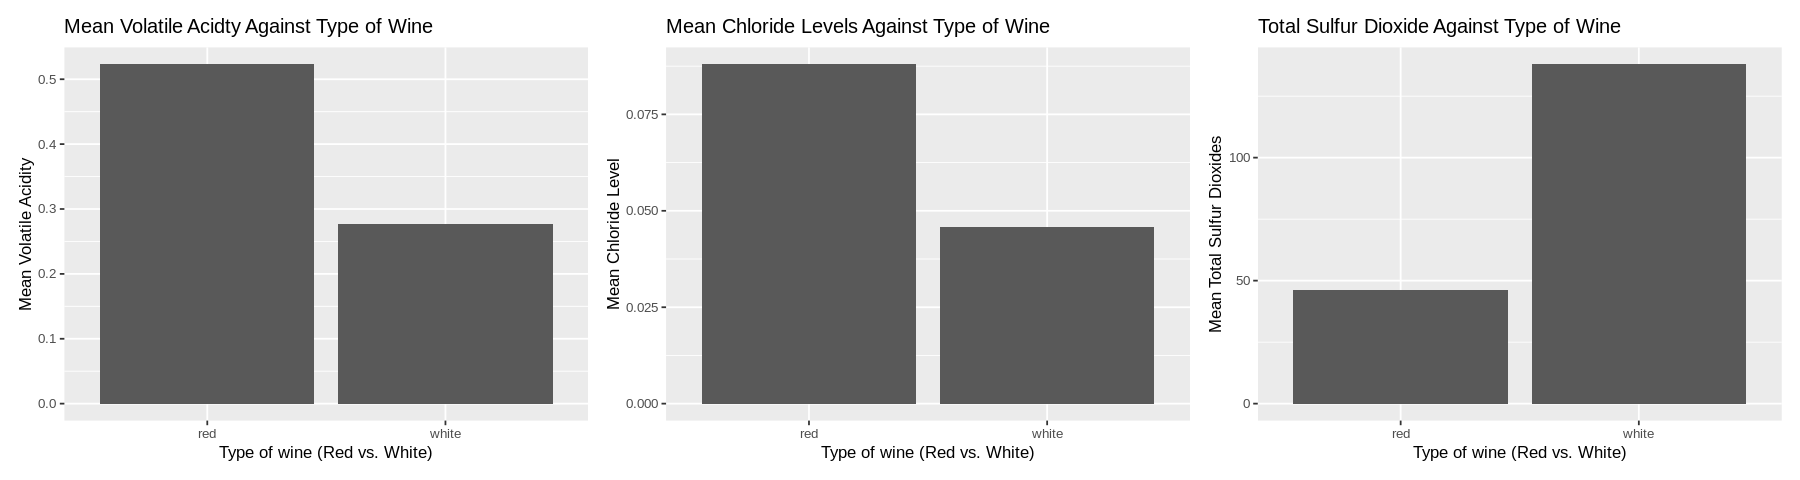

In [6]:

options(repr.plot.height = 4, repr.plot.width = 15)
plot_wine_vol <- wine_table |>
                    ggplot(aes(x= type, y=mean.vol))+
                           geom_bar(stat = "identity") +
                           labs(x = "Type of wine (Red vs. White)", y =  "Mean Volatile Acidity", 
                                title = "Mean Volatile Acidty Against Type of Wine")+
                                theme(text = element_text(size = 10))
                        

plot_wine_chlor <- wine_table |>
                    ggplot(aes(x= type, y=mean.chlor))+
                           geom_bar(stat = "identity") +
                           labs(x = "Type of wine (Red vs. White)", y = "Mean Chloride Level", 
                                title = "Mean Chloride Levels Against Type of Wine")+
                                theme(text = element_text(size = 10))
plot_wine_sulf <- wine_table |>
                    ggplot(aes(x= type, y=mean.sulf))+
                           geom_bar(stat = "identity") +
                           labs(x = "Type of wine (Red vs. White)", y = "Mean Total Sulfur Dioxides", 
                                title = "Total Sulfur Dioxide Against Type of Wine")+
                                theme(text = element_text(size = 10))
                            
plot_wine_vol+plot_wine_chlor+plot_wine_sulf

In [7]:
#vfold

In [8]:
wine_vfold <- vfold_cv(wine_train, v = 5, strata = type)

In [9]:
#recipe

In [10]:
wine_recipe <- recipe(type ~ volatile.acidity + chlorides + total.sulfur.dioxide , data = wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

In [11]:
#k-nearest neighbor

In [12]:
set.seed(2020)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

In [17]:
wine_fit <- workflow() |>
       add_recipe(wine_recipe) |>
       add_model(knn_spec) |>
       tune_grid(resamples = wine_vfold, grid = 10) |>
       collect_metrics()

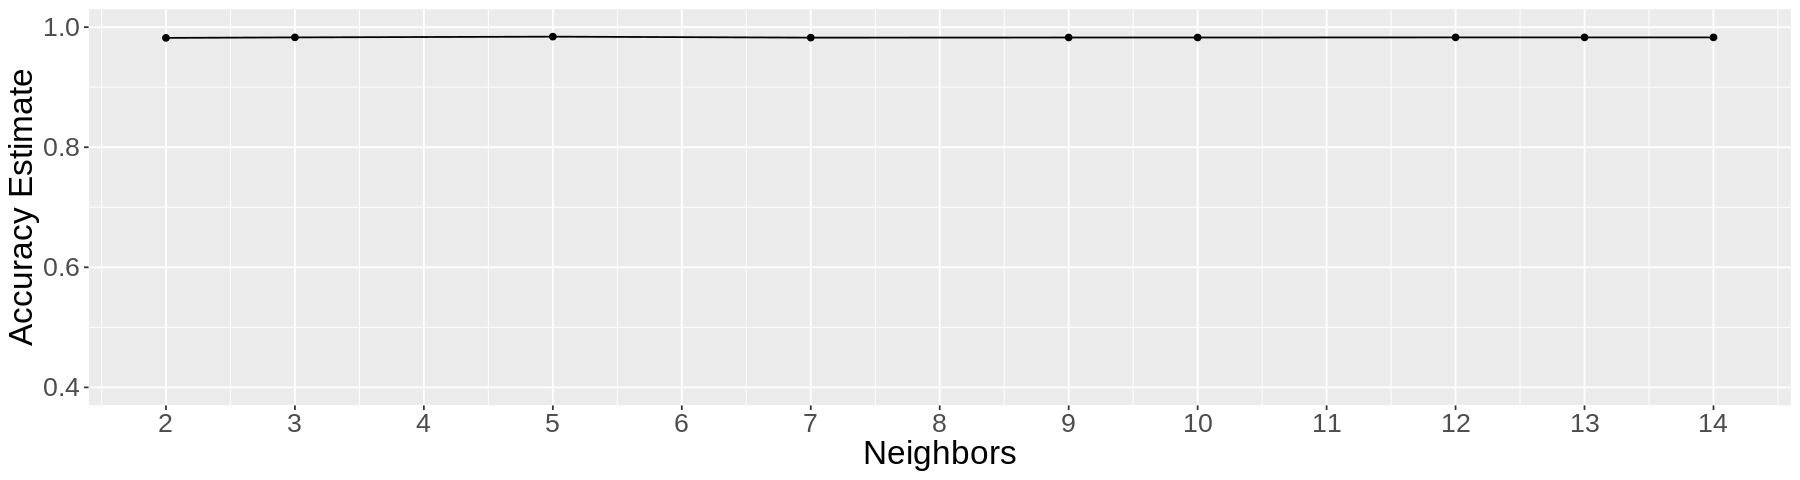

In [18]:
accuracies <- wine_fit |>
              filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                     geom_point() +
                     geom_line() +
                     labs(x = "Neighbors", y = "Accuracy Estimate") +
                     theme(text = element_text(size = 20)) +
                     scale_x_continuous(breaks = seq(0, 14, by = 1)) +
                     scale_y_continuous(limits = c(0.4, 1.0))
accuracy_versus_k

In [19]:
#choose k value

In [20]:
set.seed(9999) 

wine_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
       set_engine("kknn") |>
       set_mode("classification")

wine_fit <- workflow() |>
             add_recipe(wine_recipe) |>
             add_model(wine_spec) |>
            fit(data = wine_train)
wine_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.02097039
Best kernel: rectangular
Best k: 2

In [22]:
set.seed(9999) 

wine_predictions <- predict(wine_fit, wine_test) |>
                        bind_cols(wine_test)

wine_metrics <- wine_predictions |> metrics(truth = type, estimate = .pred_class)
wine_conf_mat <- wine_predictions |>
                        conf_mat(truth = type, estimate = .pred_class) 
wine_metrics
wine_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9790511
kap,binary,0.9442562


          Truth
Prediction  red white
     red    390    24
     white   10  1199

In [18]:
#visualization

In [23]:
pred_final <- wine_predictions|>
            mutate(predicted.type = .pred_class)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



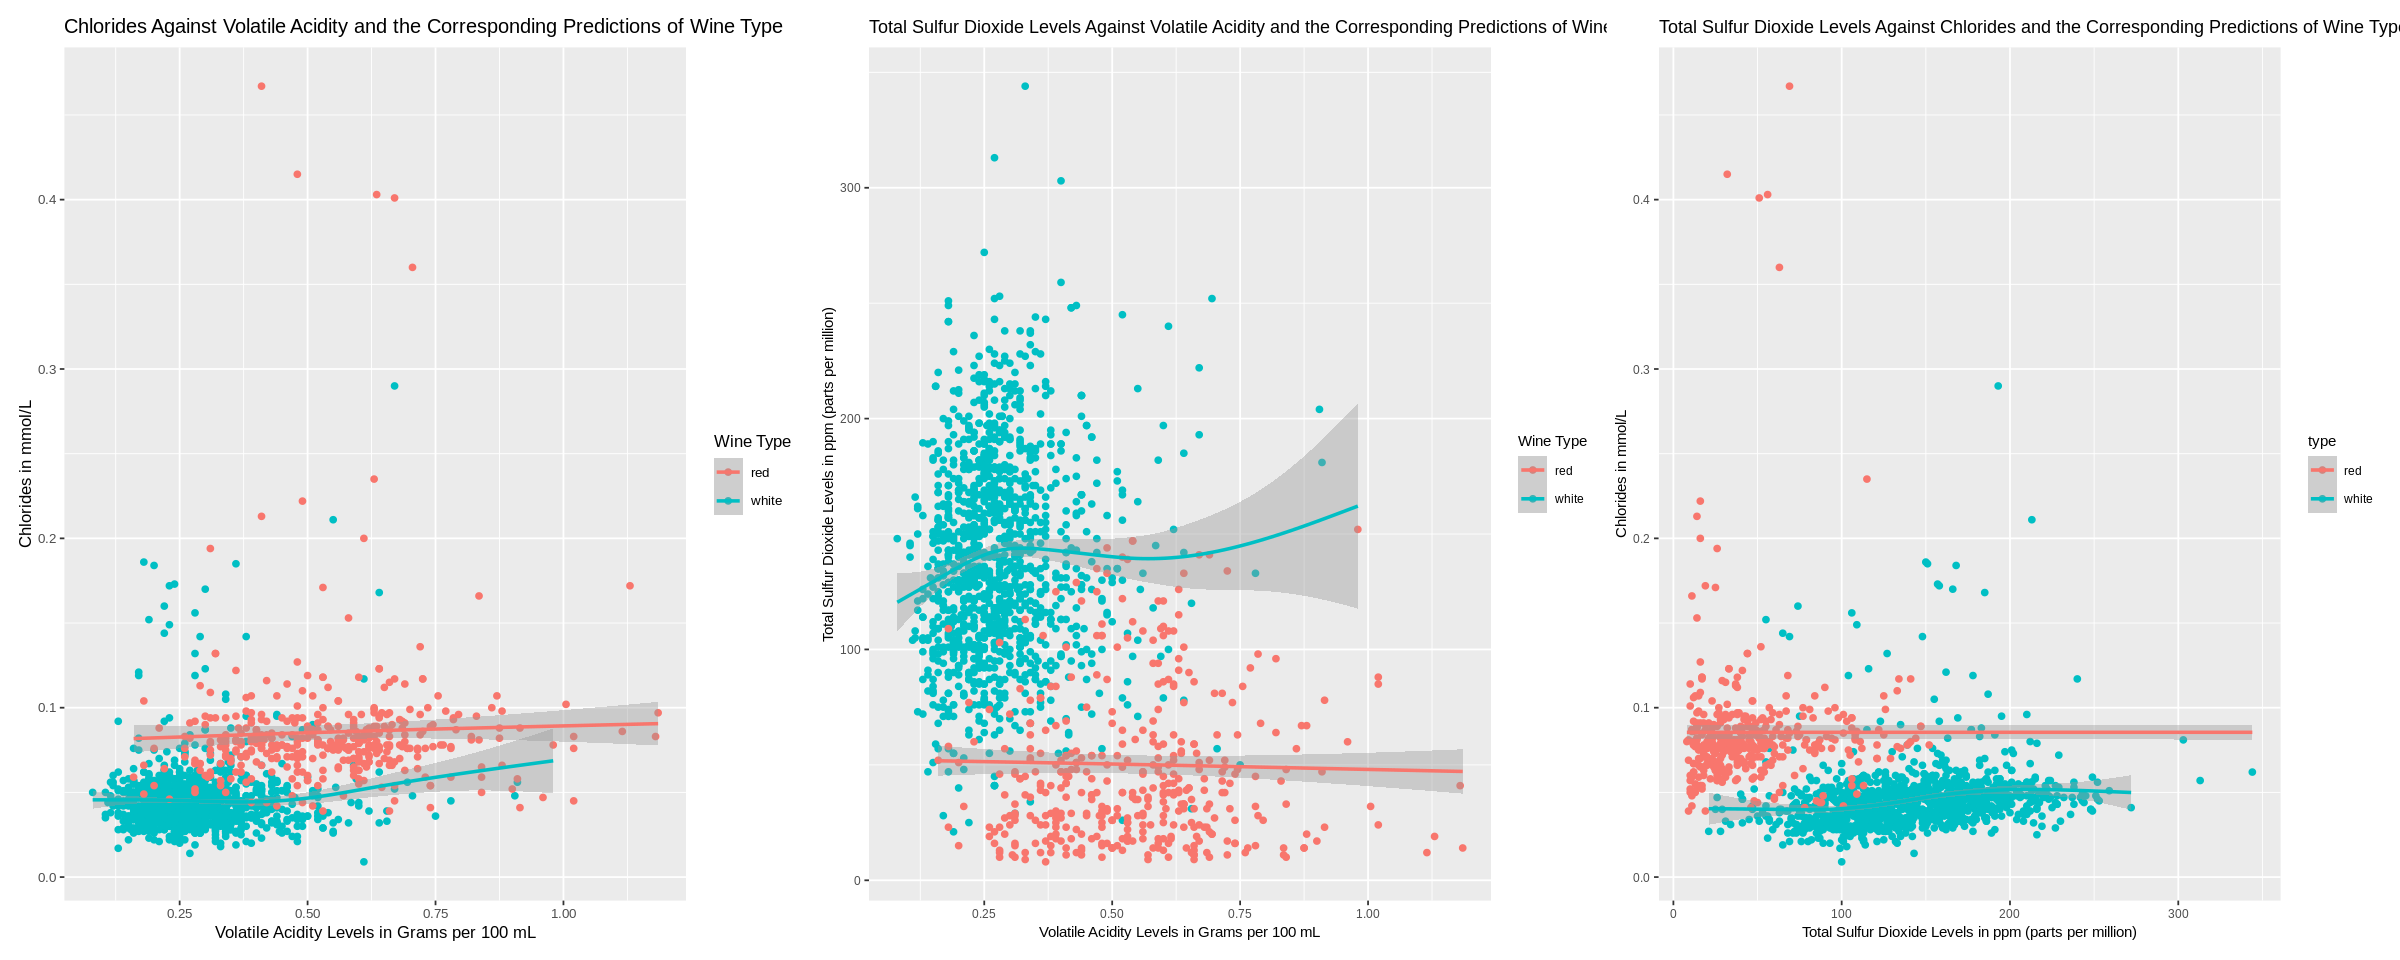

In [39]:
options(repr.plot.height = 8, repr.plot.width = 20)
wine_plot_avc <- wine_test|>
                ggplot(aes(x=volatile.acidity, y = chlorides, color = type))+
                geom_point()+
                geom_smooth(data = pred_final, aes(x = volatile.acidity, y = chlorides, color = predicted.type))+
                labs(x = "Volatile Acidity Levels in Grams per 100 mL", y = "Chlorides in mmol/L", 
                     title = "Chlorides Against Volatile Acidity and the Corresponding Predictions of Wine Type",
                    color = "Wine Type")+
                theme(text = element_text(size = 10))
wine_plot_avt <- wine_test|>
                ggplot(aes(x=volatile.acidity, y = total.sulfur.dioxide, color = type))+
                geom_point()+
                geom_smooth(data = pred_final, aes(x = volatile.acidity, y = total.sulfur.dioxide, color = predicted.type))+
                labs(x = "Volatile Acidity Levels in Grams per 100 mL", y = "Total Sulfur Dioxide Levels in ppm (parts per million)", 
                     title = "Total Sulfur Dioxide Levels Against Volatile Acidity and the Corresponding Predictions of Wine Type",
                    color = "Wine Type")+
                theme(text = element_text(size = 9))
wine_plot_tvc <- wine_test|>
                ggplot(aes(x=total.sulfur.dioxide, y = chlorides, color = type))+
                geom_point()+
                geom_smooth(data = pred_final, aes(x = total.sulfur.dioxide, y = chlorides, color = predicted.type))+
                labs(x = "Total Sulfur Dioxide Levels in ppm (parts per million)", y = "Chlorides in mmol/L", 
                     title = "Total Sulfur Dioxide Levels Against Chlorides and the Corresponding Predictions of Wine Type")+
                theme(text = element_text(size = 9))
wine_plot_avc + wine_plot_avt + wine_plot_tvc